# Проект по парсингу вакансий с телеграмм каналов и анализу данных

1.   Постановка задачи
2.   Предобработка данных



## Постановка задачи: 

Проект: Парсер телеграм-каналов с вакансиями, EDA


Цель мастерской: получить данные по вакансиям с телеграмм-каналов, провести исследовательский анализ и собрать все результаты в виде наглядной визуализации


Техническое задание:
написать парсер вакансий с телеграмм-каналов

*   провести исследовательский анализ данных:
*   определить основные критерии, по которым будем изучать количество вакансий (например, город, уровень зп, набор скиллов и тд)
*   провести анализ текущей ситуации и сравнить с историческими данными (за квартал, 2 месяца, месяц, сейчас)
*   составить **портрет типичного аналитика данных** уровня джун, джун+, миддл и тд
*   дополнительные инсайты, которые найдете в данных
*   собрать все результаты в хорошо-наглядный, читаемый дашборд или ноутбук с визуализациями



Этапы выполнения работы:
предоставить на ревью макет визуализации
парсер ( можно 1 и 2 пункты делать параллельно)
исследовательский анализ
сборка дашборда

Список телеграмм - каналов:
*  https://t.me/data_hr
*   https://t.me/biheadhunter
*  https://t.me/datajobschannel
* https://t.me/datajobs
* https://t.me/analysts_hunter
* https://t.me/datajob
* https://t.me/analyst_job
* https://t.me/foranalysts
* https://t.me/bds_job
* https://t.me/datajobschannel
* https://t.me/datasciencejobs




# Предобработка данных

### Импорт библиотек

In [158]:

import requests
import numpy as np
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pandas as pd
import json
from datetime import datetime
import re
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets

In [159]:
from google.colab import drive
drive.mount('/content/drive/')
%cp /content/drive/MyDrive/Telega_parser/telegram_den.csv telegram_den.csv



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [160]:
%cp /content/drive/MyDrive/Telega_parser/data.csv data.csv

In [161]:
%cp /content/drive/MyDrive/Telega_parser/data_full.csv data_full.csv

In [162]:
%cp /content/drive/MyDrive/Telega_parser/vac_zp.csv vac_zp.csv

### Загрузим полученный файл

In [163]:
telegram = pd.read_csv('telegram_den.csv')

In [164]:
telegram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chat        5308 non-null   object
 1   message_id  8308 non-null   int64 
 2   date        8308 non-null   object
 3   text        7717 non-null   object
 4   entities    6309 non-null   object
dtypes: int64(1), object(4)
memory usage: 324.7+ KB


Вывод: у нас в датасете мнего мусорных сообщений (пустые текстовые строки) удалим весь флуд


In [165]:
telegram = telegram.dropna().reset_index(drop=True) #сбросим индекс

Удалить раздел #### Преобразуем дату

In [166]:
telegram.date = pd.to_datetime(telegram['date'])

In [167]:
telegram['date'].min()

Timestamp('2019-01-30 00:02:49')

Вывод: данные скачаны начиная с 30 января 2019 года. 

#### Достанем из столбца чат в фомате json IDшник и название чата

In [168]:
telegram["chat_id"] = telegram["chat"].apply(lambda x: json.loads(x)['id'])
telegram["title"] = telegram["chat"].apply(lambda x: json.loads(x)['title'])

In [169]:
telegram["title"].unique()

array(['Data Analytics Jobs', 'Business Intelligence HeadHunter',
       'Data jobs feed', "IT's Tinkoff jobs",
       'Data jobs — вакансии по data science, анализу данных, аналитике, искусственному интеллекту',
       'Job for Analysts & Data Scientists', 'Big Data Science job',
       'Data Science Jobs / AI / NN / ML / DL / NLP', 'MegaFon Jobs'],
      dtype=object)

In [170]:
telegram.head(2)

,chat,message_id,date,text,entities,chat_id,title
0,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",247,2022-04-28 15:16:54,"Стажировка Ozon Camp (продакт, проджект, анали...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs
1,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",246,2022-04-22 19:10:28,вакансия #аналитик #BigData #МастерДанные #Про...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs


###<b>Проверка на дубли</b>\

Логика поика: искать обсолютно идентичные текстовые описания вакансия в разных каналах. Таким образом исключим ситуации, когда одна ваканчия публикуется в нескольких каналах

In [171]:
telegram.shape

(4830, 7)

In [172]:
telegram = telegram[~telegram['text'].duplicated()].sort_values(by='text')

In [173]:
telegram.sort_values(by = 'text', ascending = False).head(20)

,chat,message_id,date,text,entities,chat_id,title
4531,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",294,2020-11-16 14:12:08,🧮 Практические навыки в математике — основное ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001321264581,Data Science Jobs / AI / NN / ML / DL / NLP
1012,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1037,2021-11-08 22:47:38,🧑‍💻Вакансия#HadoopDevOps\n📍Компания: Самокат\n...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed
210,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",4,2020-07-29 22:27:44,🧑‍💻ВКонтакте в поиске аналитика-разработчика в...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs
200,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",17,2020-09-01 13:38:28,"🦙eLama, бренд международной IT-компании, работ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs
3633,"{\n ""_"": ""Chat"",\n ""id"": -1001164864072,...",435,2021-09-07 13:23:18,🦉OTUS – образовательная платформа🦉\n\nOTUS не ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001164864072,Big Data Science job
524,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",194,2020-08-19 22:36:57,🤓Компания AnyClass.com ищет в команду веб-анал...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter
984,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1069,2021-11-16 23:19:58,🟣ПРОДУКТОВЫЙ АНАЛИТИК🟣\nКомпания: Х5 Retail Gr...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed
58,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",179,2021-12-22 15:01:38,🟣 Системный аналитик 🟣 \n \n📌Компания: рос...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs
198,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",20,2020-10-07 18:11:12,🟢Компания СИБУР в поисках Архитектора/Аналитик...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs
2185,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",341,2022-03-20 22:00:01,🛠 Как за 3 простых шага создать свой VPN и про...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001483488834,"Data jobs — вакансии по data science, анализу ..."


In [174]:
telegram.shape

(3887, 7)

Вывод: избавились практически от 1000 строк дублей

###<b>Используем регулярные выражения, чтобы получить нужное в сообщениях</b>\
https://docs.python.org/3/library/re.html \
https://regex101.com/


Что выьягиваем на первом этапе:

Категорию вакансии: 


*   Дата Сайнс (ds)
*   Дата Аналтик (da)
*  Дата Инженер (de)





In [175]:
ds = r'ds|scien|дс|cаен|tensorflow|pytorch|сай?е?нтист|исследовател|researcher|science|\Wds\W|\Wml\W'
da = r'analyst|analysis|аналитик|bi|business intelligence|биай|tableau'
de = r'engineer|инженер|spark|airflow|architect|архитектор'



#### Пометим True или False там где у нас совпадение

In [176]:
telegram['ds'] = telegram['text'].apply(lambda x: True if re.search(ds, x.lower()) else False)
telegram['da'] = telegram['text'].apply(lambda x: True if re.search(da, x.lower()) else False)
telegram['de'] = telegram['text'].apply(lambda x: True if re.search(de, x.lower()) else False)


In [177]:
#print(telegram.iloc[60]['text'])

**Посмотрим перечесение по всем трем категориям профессий** 

In [178]:
telegram[(telegram['da']) & (telegram['ds']) & (telegram['de'])]

,chat,message_id,date,text,entities,chat_id,title,ds,da,de
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True
1713,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",248,2020-03-02 20:10:43,#BIanalyst #BIdeveloper #PowerBI #Azure #Table...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True
732,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1346,2022-03-14 20:09:03,#Berlin #релокация #BigData #DataEngineer\n\n📍...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True
...,...,...,...,...,...,...,...,...,...,...
3781,"{\n ""_"": ""Chat"",\n ""id"": -1001164864072,...",283,2021-06-22 17:13:46,🔝Middle/ Senior Data analyst в Ситимобил\nСити...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001164864072,Big Data Science job,True,True,True
4738,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",43,2020-01-26 22:42:10,🔥Ищем в команду: “Senior Big Data Engineer”\n🗺...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001321264581,Data Science Jobs / AI / NN / ML / DL / NLP,True,True,True
1421,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",590,2021-03-18 16:59:15,🚨Классные вакансии в X5 Retail Group (подразде...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True
198,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",20,2020-10-07 18:11:12,🟢Компания СИБУР в поисках Архитектора/Аналитик...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs,True,True,True


Вывод: 604 вакансия входит во все три группы, что мы определили

**308  вакансии не имеют категории. Нужно с ними отдельно разбираться
Возможно, это мусорные сообщения или реклама  и их стоит удалить **

Для ответа на этот вопрос просмотрим 30 текстовых сообщений в ручном режиме с шагом в 10 сообщений 
Сделаем для этого временнуб таблицу 

In [179]:
temple = telegram[~(telegram['da']) & (~telegram['ds']) & (~telegram['de'])]

In [180]:
temple.reset_index()

,index,chat,message_id,date,text,entities,chat_id,title,ds,da,de
0,1024,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1022,2021-11-01 19:47:08,#Consultant #Вакансия #Job #Работа #Гибридный_...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,False,False
1,472,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",272,2020-10-22 19:41:30,#Qlik #Москва #вакансия #удаленка \nКрупная фа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,False,False
2,458,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",294,2020-11-05 16:43:31,#Qlik #Москва #вакансия #удаленка В компанию S...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,False,False
3,498,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",235,2020-09-27 01:15:15,#Qlik #Москва #вакансия #удаленка В консорциум...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,False,False
4,1802,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",140,2019-09-20 16:37:55,#hadoop #teradata #oracle #datalake\n\nВсем до...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
303,2209,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",315,2022-02-12 23:00:07,👔 Специалист Computer Vision\n⛳️ Медицинские С...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001483488834,"Data jobs — вакансии по data science, анализу ...",False,False,False
304,2324,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",182,2021-07-09 23:01:27,👔 Специалист Computer Vision\n⛳️ Медицинские С...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001483488834,"Data jobs — вакансии по data science, анализу ...",False,False,False
305,2188,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",338,2022-03-18 22:00:10,👨‍💻«Библиотека программиста» открывает набор в...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001483488834,"Data jobs — вакансии по data science, анализу ...",False,False,False
306,2164,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",367,2022-04-15 18:46:26,👨‍💻🏠 Как стать фрилансером и где найти первый ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001483488834,"Data jobs — вакансии по data science, анализу ...",False,False,False


In [181]:
temple.iloc[1]['text']

'#Qlik #Москва #вакансия #удаленка \nКрупная фармацевтическая компания сейчас в поиске разработчика QlikView.\n\nВилка: 150-230 на руки (штат/ИП)\n\nОбязанности:\n\nРазработка и сопровождение решений в системе QlikView\nКонтроль выполнения текущих процедур сбора данных\nПоддержка и обучение пользователей\nНаписание технической документации\n\nТребования:\n\nВысшее образование, желательно техническое\nПрактический опыт разработки моделей данных любой сложности, дашбордов и отчетных форм на платформе QlikView.\nПрактический опыт сопровождения инфраструктуры QlikView, настройки прав доступа пользователей.\nБазовые знания по архитектуре реляционных СУБД. Приветствуется опыт написания SQL-запросов.\nПриветствуются навыки разработки скриптов на языках powershell, python и т.п., а также опыт написания макросов VBA.\nХорошее знание MS Excel.\n\nУсловия:\n\nОформление в соответствии ТК РФ в штат Компании или по ИП;\nКонкурентоспособная заработная плата;\nБонусы по итогам успешного выполнения пл

In [182]:
temple.iloc[10]['text']

'#СПБ #Газпромнефть #fulltime\nЗП от 60 тыс.рублей до 150 тыс.рублей\nВ поисках разработчика QlikView:                                                                                                         Разработка аналитических приложений на базе платформы QlikView.\nРазработка процедур загрузки данных из внешних источников для приложений на платформе QlikView.\nКонсультации и поддержка пользователей аналитических приложений на базе платформы QlikView.\nДокументация разработанных и находящихся на поддержке решений на базе платформы QlikView.\nУчастие в процессе тестирования и передачи заказчику разработанных решений (анализ тестовых сценариев, подготовка сценариев демонстрации решений заказчику)                                            Контакты: @GoncharovaIT'

In [183]:
temple.iloc[20]['text']

'#вакансия #ozon #спб\nРазработчик MS SQL (OLTP), опыт 2-3 года\nвилка: 120-180+ net (но можно обсуждать)\nофис: пл. Ал. Невского (пока удаленка или частичная удаленка)\nзадачи: разработка нового бизнес функционала + сервисы\nрезюме и вопросы: @WizarD51 \nпочта: niproskuryakov@ozon.ru\n\nЕсть также позиции в Мск, вилка по ним иная. (не моя команда)\nЗа информацией можно также ко мне.'

In [184]:
temple.iloc[30]['text']

'#вакансия #технолог #дбо #россия #удаленно\n\nВакансия: Технолог ДБО (Банк)\nКомпания Код Подбора\nЛокация #россия \nЗ/п: 200 – 240k gross\n\n\nОбязанности:\nсбор и анализ требований\nпроведение предварительного анализа и проектирование интеграционного решения\nразработка FSD\nпроработка архитектуры решения в рамках проекта создания интернет банка корпоративных клиентов\nпроектирование кросс-системных взаимодействий\nсогласование тест-кейсов\nкоординация команды разработчиков\nучастие в процессе приемки и внедрения задач \nучастие в процессах сопровождения системы (3-я линия)\n\nТребования: \nопыт командной разработки\nопыт проектирования бизнес-процессов \nопыт проектирования web-приложений \nопыт проектирования моделей данных \nопыт проектирования кросс-системных взаимодействий \nзнание XML, XSD, JSON \nзнание SQL \nзнание UML – желательно\n\nКонтакты: dashikin88'

In [185]:
temple.iloc[40]['text']

'(Тимир (@usualreptiloid) оч оч классный, всем писать #2)'

In [186]:
temple.iloc[50]['text']

'@helen09977'

In [187]:
temple.iloc[60]['text']

'Frontend-разработчик (Angular) ⌨️\nВ Тинькофф большое angular-комьюнити — у нас работают более 100 разработчиков. Мы разрабатываем десятки SPA приложений: Тинькофф Бизнес, Тинькофф.CRM, наш внутренний мессенджер, различные HR-проекты, BPM и многое другое. Так что нам нужно еще больше профессионалов! Ищем сильного frontend-разработка (Angular). \n\n➡️ Как работается фронтендерам в Тинькофф можно почитать здесь: https://l.tinkoff.ru/frontend-tinkoff\n\nЧто вам точно понадобится:\n— уверенное знание основ JavaScript;\n— опыт работы с Angular;\n— опыт работы в agile команде;\n— понимание работы веб-приложений (http протокол, Rest API);\n— умение проводить качественное код-ревью.\n\nЧем вы будете заниматься: \n— разрабатывать SPA приложения для проектов Тинькофф;\n— участвовать в командной разработке;\n— совершенствовать технические инструментов;\n— внедрять новые технологии и практики.\n\nМесто жительства не принципиально: можно работать в одном из наших офисов, можно удаленно.\n\nБольше 

Вывод: просмотренные выборочно из таблицы выше тексты позваоляют сделать выод, что это не про аналитиков данных. 
Это про разработчиков и прочие професссии

Можно удалить эти строки из датасета как не профильные вакансии
## Разобраться с этим!!! 

In [31]:
#data = telegram.query('da == False & ds == False & de == False')

### Достанем все ссылки

In [188]:
def get_links(x, regexp='http\S+'): ###
    try:
        for i in json.loads(x['entities']):
            if i['type'] == 'MessageEntityType.TEXT_LINK':
                return i['url']
            elif i['type'] == 'MessageEntityType.URL':
                url = re.findall(regexp, x['text'])[0]
                return url
    except:
        return None

In [189]:
telegram['url'] = telegram.apply(get_links, axis=1)

In [190]:
telegram.head()

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,url
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,None
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,None
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,https://engels.hh.ru/vacancy/51632135?hhtmFrom...
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,None
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,None


Вывод: В базе осталост 2 487 строк, из которых ссылка на описание вакансий есть только у половины. 



###! Часть 2. Обогащение данныъ
Так как Парсинг ссылок занимает около 2х часов - то код закоминтен!
Ссылки спаршены и загружены как отдельный датасет!!!!!!!
# Не запускать код ниже!

### Парсим ссылки

Документация BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/ 
      

In [58]:
def parse_site(url, element='div', extra_info=None):
    try:
        data = requests.get(url).text ###
        soup = BeautifulSoup(data)
        elements = []
        for extra in extra_info:
            elements += soup.find_all(element, extra)
        html = ''
        for i in elements:
            html += str(i)
        return html
    except Exception as e:
        return '<p>Не удалось получить элемент</p>'

Проверим содержимое

In [60]:
HTML(parse_site(data['url'][1], extra_info=[{'class': 'list-parent vacancy-desc'}]))

NameError: ignored

Нужно перебрать все варианты блоков, где отображена информация о вакансиях.\
Если у нас часто встречаются одни и те же сайты, можно взять доп информацию о блоке и указать ее 

In [ ]:
#заранее добавили какие есть классы на рассматриваемых сайтах

extra_infos = [{'class': 'list-parent vacancy-desc'}, 
               {'class': 'bp-Vacancy__description bp-VacancyDescription'}, 
               {'id': 'vacancy-description'},
               {'class': 'section__block panel js-show'},
               {'class': 'mb-4'},
               {'class': 'tags'},
               {'class': 'category'},
               {'class': 'location'},
               {'class': 'jobinfo'} ]

###


In [ ]:
#telegram['parsed_text'] = telegram['url'].apply(lambda x: parse_site(x, extra_info=extra_infos))


Так как в результате парсинга (2 часа времен + спарсилось не больше 30% текстов ссылок, то ценности в этих данных нет. Продолжим работать с исходным файлом

### Часть 3. Обогащщаем данные 

In [191]:
df = telegram

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3887 entries, 276 to 4531
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   chat        3887 non-null   object        
 1   message_id  3887 non-null   int64         
 2   date        3887 non-null   datetime64[ns]
 3   text        3887 non-null   object        
 4   entities    3887 non-null   object        
 5   chat_id     3887 non-null   int64         
 6   title       3887 non-null   object        
 7   ds          3887 non-null   bool          
 8   da          3887 non-null   bool          
 9   de          3887 non-null   bool          
 10  url         2059 non-null   object        
dtypes: bool(3), datetime64[ns](1), int64(2), object(5)
memory usage: 284.7+ KB


## Начнем обогащать датасет категориями данных через регулярные выражения

### Вытащим информацию о

* грейдах: джун, мидл, синиор, лид
* тип, удаленка или офис

In [193]:
rel =  r'relocate|reloc|релокац|релокация|Релокейт|релокейт'
jun =  r'junior|Junior|джун|начинающ|стаж[её]р'
middle = r'Middle|middle|\Wмидл|миддл|2-х лет'
senior =  r'Senior|senior|синьор|сеньор|\Wстарш|5 лет'
lead = r'senior|синьор|сеньор|\Wстарш|Руководител|руководител'
remote = r'Удалёнка|удалёнка|Удаленка|удален|remote|Remote|удалённо|Удалён'
gibrid = r'гибрид|Гибрид|gibrid|Gibrid'
office = r'офис|Офис'	

In [194]:
# грейд 
df['junior'] = df['text'].apply(lambda x: True if re.search(jun, x.lower()) else False)
df['middle'] = df['text'].apply(lambda x: True if re.search(middle, x.lower()) else False)
df['senior'] = df['text'].apply(lambda x: True if re.search(senior, x.lower()) else False)
df['lead'] = df['text'].apply(lambda x: True if re.search(lead, x.lower()) else False)



# Тип занятости

df['remote'] = df['text'].apply(lambda x: True if re.search(remote, x.lower()) else False)
df['gibrid'] = df['text'].apply(lambda x: True if re.search(gibrid, x.lower()) else False)
df['office'] = df['text'].apply(lambda x: True if re.search(office, x.lower()) else False)




In [195]:
df.head()

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,url,junior,middle,senior,lead,remote,gibrid,office
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,None,False,False,False,False,False,False,False
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,None,False,False,True,True,True,False,False
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,https://engels.hh.ru/vacancy/51632135?hhtmFrom...,True,False,False,False,True,False,True
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,None,False,True,False,False,True,False,True
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,None,False,False,False,False,False,False,False


Вывод: у нас получилась куча столбцоы, приведем их к единообразицю
Лямбда фунцию в спаршенному тексту применяли на случай проверки отсутствующей информации из описания (если нет данных)

### Выведем все Грейдф в одну колонку

In [196]:
df['grade'] = ""
df['grade'].astype('str')

for index, row in df.iterrows():
  if df['junior'][index] == True:
    df['grade'][index] = 'junior'
  elif df['middle'][index] == True:
    df['grade'][index] = 'middle'
  elif df['senior'][index] == True:
    df['grade'][index] = 'senior'
  elif df['lead'][index] == True:
    df['grade'][index] = 'lead'
  else:
    df['grade'][index] = 'not_defined'
         




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

In [197]:
df = df.drop(columns = ['junior','middle', 'senior'])

### Выведем все Типы занятости в одну колонку

In [198]:
df['type_office'] = ""
df['type_office'].astype('str')

for index, row in df.iterrows():
  if df['remote'][index] == True:
    df['type_office'][index] = 'remote'
  elif df['gibrid'][index] == True:
    df['type_office'][index] = 'gibrid'
  elif df['office'][index] == True:
    df['type_office'][index] = 'office'
  else:
    df['type_office'][index] = 'not_defined'
         



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-pa

In [199]:
df.head(1)

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,url,lead,remote,gibrid,office,grade,type_office
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,None,False,False,False,False,not_defined,not_defined


In [200]:
df = df.drop(columns = ['remote', 'gibrid','office'])

In [201]:
df.head(2)

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,url,lead,grade,type_office
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,None,False,not_defined,not_defined
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,None,True,senior,remote


### добавим  регулярки для самых крупных городов: Москва, СПБ, Новосибирск, Екатеринбург, Казань
а также добавим вакансии с релокацией как город "Релокация"

In [202]:
Mow = r'moscow|москв[аеы]|мск'
Spb = r'saint\Wpetersburg|санкт-петербург[ае]?|питер[ае]?|спб'
Novosib = r'novosibirsk|новосибирск[ае]?'
Ekat = r'y?ekaterinburg|екатеринбург[ае]'
Kazan = r'\Wkazan\W|\Wказан[ьи]'
rel =  r'relocate|reloc|релокац|релокация|Релокейт|релокейт'


In [203]:
# применим для сообщений в канале
df['Mow'] = df['text'].apply(lambda x: True if re.search(Mow, x.lower()) else False)
df['Spb'] = df['text'].apply(lambda x: True if re.search(Spb, x.lower()) else False)
df['Novosib'] = df['text'].apply(lambda x: True if re.search(Novosib, x.lower()) else False)
df['Ekat'] = df['text'].apply(lambda x: True if re.search(Ekat, x.lower()) else False)
df['Kazan'] = df['text'].apply(lambda x: True if re.search(Kazan, x.lower()) else False)
df['relocation'] = df['text'].apply(lambda x: True if re.search(rel, x.lower()) else False)



In [204]:
# Соберем все города в одну колонку

df['city'] = ""
df['city'].astype('str')

for index, row in df.iterrows():
  if df['Mow'][index] == True:
    df['city'][index] = 'Moscow'
  elif df['Spb'][index] == True:
    df['city'][index] = 'Spb'
  elif df['Novosib'][index] == True:
    df['city'][index] = 'Novosibirsk'
  elif df['Ekat'][index] == True:
    df['city'][index] = 'Ekatirinburg'
  elif df['Kazan'][index] == True:
    df['city'][index] = 'Kazan'
  elif df['relocation'][index] == True:
    df['city'][index] = 'relocation'
  else:
    df['city'][index] = 'not_defined'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to

In [205]:
df.head(1)

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,lead,grade,type_office,Mow,Spb,Novosib,Ekat,Kazan,relocation,city
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,False,not_defined,not_defined,False,False,False,False,False,False,not_defined


In [206]:
df = df.drop(columns = ['Mow', 'Spb','Novosib', 'Ekat','Kazan','relocation'])

# Попробуем разобраться с самыми популярными навыками через токенизацию и стемминг

Сделаем копию колонки текста, иначе все может поломаться потом) 

## Токенизация

In [207]:
import nltk

In [208]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [209]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [210]:
 #делаем копию колонки с текстом 
df['text_copy'] = df['text'].str.lower()

In [211]:
df['text_copy'] = df['text_copy'].str.replace('[{}]'.format(string.punctuation), '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [212]:
# сделали колонки с блоками, ее будем анализировать на предмет вакансий
df = df.assign(blocks = lambda x: x['text_copy'].apply(lambda x: x.split(sep='\n')[0]))
'xxxx <strong> yyyyy <strong> zzzzz'. split(sep='\n')[0]

'xxxx <strong> yyyyy <strong> zzzzz'

In [213]:
df['blocks'][2422]

'главный аналитикматематик data analyst  datascientist в москве'

In [214]:
#  сделаем токенизацию наших блоков текста
tokenized = df['blocks'].apply(nltk.word_tokenize)

In [215]:
#  привет ревьюер! вот тут не смогла побелить установку стоп-словчто не так? #
 
#import nltk
#nltk.download('stopwords')
#print(stopwords.words('russian'))

In [216]:
#stop_words = stopwords.words('russian')
#stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])

In [217]:
tokenized.explode()

276       вакансия
276            web
276     webanalyst
1294       bigdata
1294        python
           ...    
4531      открытых
4531    источников
4531            на
4531       октябрь
4531          2020
Name: blocks, Length: 26556, dtype: object

###Стемминг 
(чтобы избежать дублей)

In [218]:
stem = nltk.stem.snowball.RussianStemmer()

In [219]:
stem.stem('требования')
stem.stem('миддл')
stem.stem('релокация')
stem.stem('релоцироваться')

'релоцирова'

In [220]:
all_words = tokenized.explode().apply(stem.stem)

In [221]:
all_words_st = str(all_words)

In [222]:
#  вот тут пыталась исключить стоп-слова, но программа зависала минут на 20 минумум!!!!
# from nltk.corpus import stopwords

# def remove_stopwords(word_list):
        # processed_word_list = []
        # for word in word_list:
            # word = word.lower() # in case they arenet all lower cased
            # if word not in stopwords.words("russian"):
               #processed_word_list.append(word)
        # return processed_word_list

In [223]:
# all_words_st.apply(remove_stopwords)

In [224]:
all_words

276         ваканс
276            web
276     webanalyst
1294       bigdata
1294        python
           ...    
4531        открыт
4531      источник
4531            на
4531        октябр
4531          2020
Name: blocks, Length: 26556, dtype: object

In [225]:
# Сделаем датафрейм для того, что б нарисовать облачко 
words_df = all_words.to_frame()

In [226]:
temple = words_df.reset_index()

In [227]:
temple

,index,blocks
0,276,ваканс
1,276,web
2,276,webanalyst
3,1294,bigdata
4,1294,python
...,...,...
26551,4531,открыт
26552,4531,источник
26553,4531,на
26554,4531,октябр


In [228]:
temple.pivot_table(
    index = 'blocks',
    values = 'index',
    aggfunc = 'count'
).sort_values(by='index', ascending = False).head(30)

,index
blocks,
ваканс,1452
в,970
data,775
аналитик,552
москв,523
и,425
fulltime,359
python,291
scientist,289


In [229]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
text = " ".join(review for review in words_df['blocks'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 180284 words in the combination of all review.


In [231]:

stopwords = ['оп', 'компан', 'задач','ваканс', 'and', ' по', 'как', 'для', 'сервис', 'эт', 'мы', 'ПО', 'всем', 'привет']
russian_stopwords = pd.Series(stopwords)


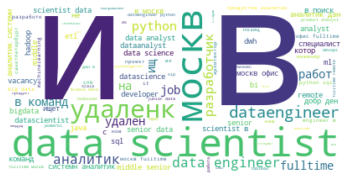

In [232]:
# Рисуем облачко
wordcloud = WordCloud(max_font_size=200, max_words=100,stopwords = russian_stopwords, background_color="white").generate(text)

# Выводим на экран:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Вывод: Основа текста - слова с Аналитиками, Москвой и Удаленкой

Уберем еще в стоп слова самые частотные и посмотрим что еще интерсного может быть в облачке

In [233]:
stopwords2 = ['оп', 'компан', 'задач','ваканс', 'and', ' по', 'как', 'для', 'сервис', 'эт', 'мы', 'ПО', 'всем', 'привет', 'аналитик', 'москв'
, 'удаленк', 'команд', 'ищет', 'ищ', 'vacanc']
russian_stopwords = pd.Series(stopwords2)

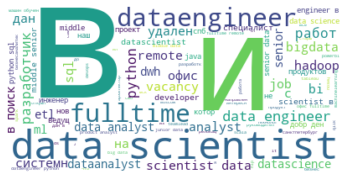

In [234]:
# Рисуем облачко
wordcloud = WordCloud(max_font_size=200, max_words=100,stopwords = russian_stopwords, background_color="white").generate(text)

# Выводим на экран:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Вытащим названия вакансий

In [235]:
# Используем знакомую тему с регулярками

#назначим регулярки

product_analyst = r'продукто|product analyst|продуктового аналитика|аналитик продукта|product data analyst'
marketing_analyst = r'marketing analyst|маркетинговый аналитик|маркетинговой аналитики|маркетингового аналитика|marketing data analyst|аналитика в команду маркетинга|маркетинг аналитик'
business_analyst = r'бизнес-аналитик|business analyst|бизнес аналитик|Бизнесаналитик'
web_analyst = r'веб-аналитик|web-аналитик|веб-продукт|digital analyst|webanalyst'
data_analyst = r'|analyst|аналитик данных'
data_engineer = r'|системный|dataengineer|engineer|system'
data_scientist = r'|scientist|саинтист|'

In [236]:
# заполним столбцы

df['product_analyst'] = df['blocks'].apply(lambda x: True if re.search(product_analyst, x.lower()) else False)
df['marketing_analyst'] = df['blocks'].apply(lambda x: True if re.search(marketing_analyst, x.lower()) else False)
df['business_analyst'] = df['blocks'].apply(lambda x: True if re.search(business_analyst, x.lower()) else False)
df['web_analyst'] = df['blocks'].apply(lambda x: True if re.search(web_analyst, x.lower()) else False)
df['data_analyst'] = df['blocks'].apply(lambda x: True if re.search(data_analyst, x.lower()) else False)
df['data_engineer'] = df['blocks'].apply(lambda x: True if re.search(data_engineer, x.lower()) else False)
df['data_scientist'] = df['blocks'].apply(lambda x: True if re.search(data_scientist, x.lower()) else False)



In [237]:
df.head(10)

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,city,text_copy,blocks,product_analyst,marketing_analyst,business_analyst,web_analyst,data_analyst,data_engineer,data_scientist
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,not_defined,вакансия web webanalyst \n\nвакансия web analy...,вакансия web webanalyst,False,False,False,True,True,True,True
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,Moscow,bigdata python вакансия работа \n\nнам ос...,bigdata python вакансия работа,False,False,False,False,True,True,True
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,Moscow,data scientist ds вакансия junior \n\nкомпан...,data scientist ds вакансия junior,False,False,False,False,True,True,True
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,...,Moscow,bi businessintelligence powerbi sql sqlserver ...,bi businessintelligence powerbi sql sqlserver ...,False,False,False,False,True,True,True
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,...,not_defined,bi greenplum clickhouse apache etl teradata \n...,bi greenplum clickhouse apache etl teradata,False,False,False,False,True,True,True
568,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",135,2020-07-23 14:54:57,#BI #powerBI #tableau \nPro Personnel ищет ана...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,False,...,not_defined,bi powerbi tableau \npro personnel ищет аналит...,bi powerbi tableau,False,False,False,False,True,True,True
480,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",263,2020-10-21 22:43:34,#BI #Москва #fulltime\nВсем привет! Ищем BI ан...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,False,...,Moscow,bi москва fulltime\nвсем привет ищем bi аналит...,bi москва fulltime,False,False,False,False,True,True,True
1713,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",248,2020-03-02 20:10:43,#BIanalyst #BIdeveloper #PowerBI #Azure #Table...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,Moscow,bianalyst bideveloper powerbi azure tableau et...,bianalyst bideveloper powerbi azure tableau etl,False,False,False,False,True,True,True
732,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1346,2022-03-14 20:09:03,#Berlin #релокация #BigData #DataEngineer\n\n📍...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,relocation,berlin релокация bigdata dataengineer\n\n📍вака...,berlin релокация bigdata dataengineer,False,False,False,False,True,True,True
4443,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",412,2021-03-06 13:45:26,#BigData #DataAnalyst #Python #SQL #machinelea...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001321264581,Data Science Jobs / AI / NN / ML / DL / NLP,False,True,False,...,Moscow,bigdata dataanalyst python sql machinelearning...,bigdata dataanalyst python sql machinelearning,False,False,False,False,True,True,True


In [238]:
# проверка на пустые значения
temple = df[~(df['product_analyst']) & (~df['marketing_analyst']) & (~df['business_analyst']) & (~df['web_analyst'])
& (~df['data_analyst'])& (~df['data_engineer'])& (~df['data_scientist'])]

In [239]:
temple.shape

(0, 24)

In [240]:
# Схлопнем все колонки с вакансиями в одну
df['name_vacancy'] = ""
df['name_vacancy'].astype('str')

for index, row in df.iterrows():
  if df['product_analyst'][index] == True:
    df['name_vacancy'][index] = 'product_analyst'
  elif df['marketing_analyst'][index] == True:
    df['name_vacancy'][index] = 'marketing_analyst'
  elif df['business_analyst'][index] == True:
    df['name_vacancy'][index] = 'business_analyst'
  elif df['web_analyst'][index] == True:
    df['name_vacancy'][index] = 'web_analyst'
  elif df['data_engineer'][index] == True:
    df['name_vacancy'][index] = 'data_engineer'
  elif df['data_scientist'][index] == True:
    df['name_vacancy'][index] = 'data_scientist'
  elif df['data_analyst'][index] == True:
    df['name_vacancy'][index] = 'data_analyst'  
  else:
    df['name_vacancy'][index] = 'not_defined'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ip

In [241]:
df.head()

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,text_copy,blocks,product_analyst,marketing_analyst,business_analyst,web_analyst,data_analyst,data_engineer,data_scientist,name_vacancy
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,вакансия web webanalyst \n\nвакансия web analy...,вакансия web webanalyst,False,False,False,True,True,True,True,web_analyst
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,bigdata python вакансия работа \n\nнам ос...,bigdata python вакансия работа,False,False,False,False,True,True,True,data_engineer
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,data scientist ds вакансия junior \n\nкомпан...,data scientist ds вакансия junior,False,False,False,False,True,True,True,data_engineer
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,...,bi businessintelligence powerbi sql sqlserver ...,bi businessintelligence powerbi sql sqlserver ...,False,False,False,False,True,True,True,data_engineer
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,...,bi greenplum clickhouse apache etl teradata \n...,bi greenplum clickhouse apache etl teradata,False,False,False,False,True,True,True,data_engineer


# Обогащаем датасет навыками

Задача один: попытаться понять какие навыки вообще имеют место быть в нашем датасете. Выдел ить совноыные и написать для них потом регулярки. Вдохновимся вот этим крутыим исследованием: https://github.com/egorborisov/jobs_article/blob/main/jobs_research.ipynb

In [242]:
# позаимствуем код вот тут
skills = {
    'TensorFlow': {'tensorflow', '\Wtf\W', 'тензорфлоу'},
    'PyTorch': {'pytorch', 'пайторч'},
    'Keras': {'keras', 'керас'},
    'Python': {'python', 'питон', 'пайтон'},
    'Pandas/numpy': {'\Wpandas\W', '\Wnumpy\W'},
    'R': {'\Wr\W'},
    'SQL': {'sql'},
    'Scala': {'scala', 'скала'},
    'Java': {'java', 'джава'},
    'Julia': {'julia', 'джули[ая]'},
    'Go': {'\Wgo\W'},
    'C++': {'c\+\+'},
    'C#': {'c#', 'шарп'},
    'Linux': {'bash', 'баш', 'linux', 'линукс'},
    'JS': {'\Wjs\W', 'java\W?script'},
    'Matlab': {'matlab', 'матлаб'},
    'Django': {'django', 'джанго'},
    'Flutter': {'flutter', 'флатт?ер'},
    'Flask': {'flask', 'фласк'},
    'Spring': {'spring'},
    'Git': {'git', 'github', 'bitbucket', 'gitlab', 'гит', 'гитхаб', 'битбакет', 'гитлаб'},
    'Docker': {'docker', 'докер'},
    'Kubernetes': {'kubernetes', 'кубернетес'},
    'Openshift': {'openshift'},
    'Grafana': {'grafana', 'графан'},
    'Power BI': {'power bi', 'powerbi', 'биай' },
    'Tableau': {'tableau', 'табло'},
    'Airflow': {'airflow', 'а[э]ирфлоу'},
    'Prometheus': {'prometheus', 'прометеус'},
    'Redshift': {'redshift'},
    'HDFS': {'hdfs'},
    'MapReduce': {'mapreduce'},
    'Spark': {'spark', 'спарк'},
    'Hive': {'hive'},
    'Azure': {'azure'},
    'Hadoop': {'hadoop', 'хадуп'},
    'Kafka': {'kafka', 'кафк[ау]'},
    'RabbitMQ': {'rabbit', 'кролик'},
    'MongoDB': {'mongo.?db'},
    'Firebase': {'firebase'},
    'Cassandra': {'cassandra'},
    'Redis': {'redis'},
    'Redshift': {'redshift'},
    'BigQuery': {'bigquery'},
    'Excel': {'\Wexcel\W', '\Wэксел\W'},
    'Clickhouse': {'clickhouse', 'кликхау[сз]'},
    'XGBoost': {'xgboost', '\Wxgb\W'},
    'LightGBM': {'lightgbm', '\Wlgb\W'},
    'CatBoost': {'catboost'},
    'Scikit-learn': {'scikit', 'sklearn'},
    'SciPy': {'scipy'},
    'MLflow': {'mlflow', 'ml flow'},
}

In [243]:
# функция для парсинга
def get_keyword_df(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['text'].str.contains(keywords_regex, regex=True)
    keywords_df = pd.DataFrame(columns=['keyword', 'number'])
    for keyword in list(keywords.keys()):
        keywords_df = keywords_df.append({'keyword': keyword, 'number': len(df[df[keyword]])}, ignore_index=True)
    keywords_df = keywords_df.sort_values(by=['number'], ascending=False).reset_index(drop=True)
    keywords_df['perc'] = keywords_df['number'] / len(df) * 100
    return keywords_df

In [244]:
keyword_df = get_keyword_df(df, skills).head(25)
skills_list = [i for i in keyword_df['keyword'].values]

TypeError: ignored

Text(36.125, 0.5, '')

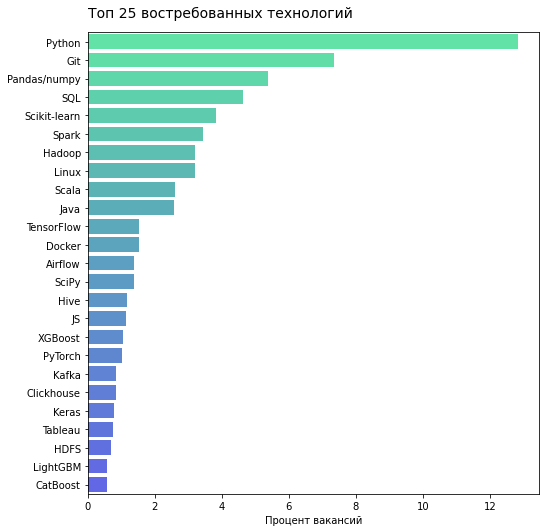

In [245]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.tight_layout(w_pad=5)

sns.barplot(ax = ax, data=keyword_df, x='perc', y='keyword', palette=sns.color_palette('winter_r', 25), alpha=0.7)
ax.set_title(label='Топ 25 востребованных технологий', loc='left', size=14, pad=15)
ax.set_xlabel('Процент вакансий')
ax.set_ylabel('')

Вывод: 
1. Как и ожидалось, качество данных так себе - макисмум в 12% текста указаны нужные нам навыки. Это пробелма всего датаспета, увы
2. Оставим в нашем датасете только колонки с топ-25 навыками. Остальные удалим

In [246]:
df.columns

Index(['chat', 'message_id', 'date', 'text', 'entities', 'chat_id', 'title',
       'ds', 'da', 'de', 'url', 'lead', 'grade', 'type_office', 'city',
       'text_copy', 'blocks', 'product_analyst', 'marketing_analyst',
       'business_analyst', 'web_analyst', 'data_analyst', 'data_engineer',
       'data_scientist', 'name_vacancy', 'TensorFlow', 'PyTorch', 'Keras',
       'Python', 'Pandas/numpy', 'R', 'SQL', 'Scala', 'Java', 'Julia', 'Go',
       'C++', 'C#', 'Linux', 'JS', 'Matlab', 'Django', 'Flutter', 'Flask',
       'Spring', 'Git', 'Docker', 'Kubernetes', 'Openshift', 'Grafana',
       'Power BI', 'Tableau', 'Airflow', 'Prometheus', 'Redshift', 'HDFS',
       'MapReduce', 'Spark', 'Hive', 'Azure', 'Hadoop', 'Kafka', 'RabbitMQ',
       'MongoDB', 'Firebase', 'Cassandra', 'Redis', 'BigQuery', 'Excel',
       'Clickhouse', 'XGBoost', 'LightGBM', 'CatBoost', 'Scikit-learn',
       'SciPy', 'MLflow'],
      dtype='object')

In [247]:
df = df.drop(columns = ['lead', 'text_copy', 'product_analyst', 'marketing_analyst', 'business_analyst'
,'web_analyst','data_analyst' , 'data_engineer', 'data_scientist','R', 'Julia', 'Go', 'C++', 'C#',
         'Matlab', 'Django', 'Flutter', 'Flask', 'Spring', 
        'Kubernetes', 'Openshift', 'Grafana', 
        'Prometheus', 'Redshift', 'HDFS', 'MapReduce',
        'Azure', 'RabbitMQ', 'MongoDB', 'Firebase',
       'Cassandra', 'Redis', 'BigQuery', 'Excel',
       'MLflow' ])


In [ ]:
df.info()

### выделим год и месяц из датасета

In [248]:
import datetime 
# for i in range(len(df)):
#   df['date_datetime'] = datetime.datetime.strptime(df.date[i],'%Y-%m-%d %H:%M:%S')

if df['date'].dtype != '<M8[ns]':
  df['date'] = pd.to_datetime(df['date'])

In [249]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [250]:
df.head()

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,Kafka,Clickhouse,XGBoost,LightGBM,CatBoost,Scikit-learn,SciPy,year,month,day
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,False,False,False,False,False,False,False,2021,10,14
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,False,False,False,False,False,False,False,2021,6,1
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,False,False,False,False,False,True,False,2022,1,24
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,...,False,False,False,False,False,False,False,2021,7,7
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,...,False,False,False,False,False,False,False,2020,1,27


### Разберемся с зарплатами

берем код и адаптируем немножко  из вот этой статьи: https://github.com/egorborisov/jobs_article/blob/main/jobs_research.ipynb



Очистка текста
В вакансиях есть много других цифр помимо зарплатных вилок, которые машают анализу. Для начала очистим текст от них:

Ссылки
Номера телефонов
Года
Интервалы времени
Премии

In [260]:
# Ссылка
link = r'<.*?>'

# Номер телефона
tel = r'([78][-\( ]*\d{3}[-\) ]*\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3}|' + \
      r'\(\d{3}\)\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3})'


year_ranges = {str(k): '' for k in range(2001,2021,1)}
time_ramges = {i:'' for i in ['5/2', '10-19', '11-18', '11-19', '9-18', 'c 11 до 19']}
bonus = r'(\+.{0,5}?\d{2,3}.{0,25}?преми|\+ \d{2-3}-\d{2,3}|\+ \d{2,3})'


In [261]:
# Очищаем текст
df['clean_text'] = df['text']
# Удаляем все ссылки из текста
df['clean_text'] = df.clean_text.str.replace(link, ' ')
# Удаляем телефоны из текста
df['clean_text'] = df.clean_text.str.replace(tel, ' ')
# Удаляем премии из текста
df['clean_text'] = df.clean_text.str.replace(bonus, ' ')
# Удаляем года из текста
df['clean_text'] = df.clean_text.replace(year_ranges, regex=True)
# Удаляем время из текста
df['clean_text'] = df.clean_text.replace(time_ramges, regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


Базовые регулярки для зарплатных вилок
Для начала сделаем несколько регулярок:

Реглярка для извеления цифрв в 4 форматах
Регулярка для выражения между цифрами если они отностятся к одной вилке
Регулярка для выражений которые часто идут до указания зарпланой вилки
Регулярка для выражений которые идут после зарплатной вилки

In [262]:
number = r'([123456789]\d{0,2}[,\'\. ]?\d0{2}|[123456789]\d{2}0{1,2}|[123456789]\d{1,2}|[123456789]\d{0,1}[\.,\']\d{1,3})'

middle = r'[ \t]*[^0123456789\.,\'%]{0,9}?(?:-|до|–|—|to|-)[ \t]*[^0123456789\.,\'%]{0,1}?'

start = r'(?:net|gross|гросс|нет|rub|$|€|£|eur|dol|mid|sen|jun|мидл|синь|джун|зп|з\\п|плат|компенсац|' + \
        r'вилк|з/п|доход|fork|moneys|salary|moneyparrot|деньг|оклад|условия|ставка|_plug).{0,100}?\s*?'

end = r'[ \t]*?[^0123456789]{0,3}?(?:k |к |тыс\.|т\.р|net|gross|гросс|нет|rub|$|€|£|eur|dol|mid|' + \
      r'sen|jun|мидл|синь|jun|р |джун)'

Финальные регулярки для извлечения вилок
Теперь из базовых регулярок можно собрать финальные. В порядке приоритета:

Полные вилки от и до
Вилки из одной цифры с совпадением по регулрякам до и после

In [263]:
fork_1 = number + middle + number
fork_2 = start + number + end

In [264]:
# Парсим вилки с использованием полученных регулярок
forks_1 = df.clean_text.str.findall(fork_1)
clean_text = df.clean_text.str.replace(fork_1, ' ')
forks_2 = clean_text.str.findall(fork_2)

forks_list = []
for i, row in df.iterrows():
    forks = forks_1[i] + forks_2[i]
    forks_list.append(forks)
    
df['forks'] = forks_list

print(f'Всего найдено вилок {np.sum(df.forks.str.len() > 0)} из {len(df)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Всего найдено вилок 1506 из 3887


In [265]:
df

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,Scikit-learn,SciPy,year,month,day,clean_text,forks,Salary_from,Salary_to,cur
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,False,False,2021,10,14,"""#вакансия #web #webanalyst \n\nВакансия: Web ...",[],0,0,Rub
1294,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",725,2021-06-01 18:59:52,# BigData #Python #вакансия #работа \n\nНа...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,False,False,2021,6,1,# BigData #Python #вакансия #работа \n\nНа...,"[(200, 300), (25, 35)]",200,300,Rub
839,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1223,2022-01-24 19:32:51,# Data scientist #DS #вакансия #Junior \n\nКо...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,True,True,True,...,True,False,2022,1,24,# Data scientist #DS #вакансия #Junior \n\nКо...,"[(100, 150)]",100,150,Rub
314,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",485,2021-07-07 15:42:10,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,True,True,True,...,False,False,2021,7,7,#BI #BusinessIntelligence #PowerBI #SQL #SQLSe...,[],0,0,Rub
1738,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",219,2020-01-27 13:54:50,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,False,...,False,False,2020,1,27,#BI #Greenplum #ClickHouse #Apache #ETL #Terad...,[200],0,0,Rub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,"{\n ""_"": ""Chat"",\n ""id"": -1001164864072,...",435,2021-09-07 13:23:18,🦉OTUS – образовательная платформа🦉\n\nOTUS не ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001164864072,Big Data Science job,False,True,True,...,False,False,2021,9,7,🦉OTUS – образовательная платформа🦉\n\nOTUS не ...,"[(1.5, 4000)]",1.5,4000,Rub
200,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",17,2020-09-01 13:38:28,"🦙eLama, бренд международной IT-компании, работ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs,False,True,False,...,False,False,2020,9,1,"🦙eLama, бренд международной IT-компании, работ...",[30],0,0,Rub
210,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",4,2020-07-29 22:27:44,🧑‍💻ВКонтакте в поиске аналитика-разработчика в...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269328727,Data Analytics Jobs,True,True,True,...,False,False,2020,7,29,🧑‍💻ВКонтакте в поиске аналитика-разработчика в...,[],0,0,Rub
1012,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1037,2021-11-08 22:47:38,🧑‍💻Вакансия#HadoopDevOps\n📍Компания: Самокат\n...,"[\n {\n ""_"": ""MessageEntity"",\n ...",-1001269377842,Data jobs feed,False,True,True,...,False,False,2021,11,8,🧑‍💻Вакансия#HadoopDevOps\n📍Компания: Самокат\n...,[],0,0,Rub


In [266]:
# Парсим вилки с использованием полученных регулярок
 
forks_1 = df.clean_text.str.findall(fork_1)
clean_text = df.clean_text.str.replace(fork_1, ' ')
forks_2 = clean_text.str.findall(fork_2)

df['Salary_from'] = 0
df['Salary_to'] = 0

for i, row in df.iterrows():
  if len(forks_1[i])>0:
    df['Salary_from'][i] = forks_1[i][0][0]
    df['Salary_to'][i] = forks_1[i][0][1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [267]:
df.head(1)

,chat,message_id,date,text,entities,chat_id,title,ds,da,de,...,Scikit-learn,SciPy,year,month,day,clean_text,forks,Salary_from,Salary_to,cur
276,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",536,2021-10-14 13:47:31,"""#вакансия #web #webanalyst \n\nВакансия: Web ...","[\n {\n ""_"": ""MessageEntity"",\n ...",-1001291755040,Business Intelligence HeadHunter,False,True,False,...,False,False,2021,10,14,"""#вакансия #web #webanalyst \n\nВакансия: Web ...",[],0,0,Rub


Добавим валюту и признак net или гросс
Пересчитаем зарплаты в рублях в net

In [271]:
#currency = {
    #'Usd': ['usd', '\$', 'dollar', 'доллар', 'бакс'],
    #'Euro': ['eur', '€', 'евро'],      
    #}

#tax = {
    #'Gross': ['gros', 'грос', 'до налог', 'до вычет'],
    #'Net': ['net', 'после налог', 'после вычет', 'на руки', 'чисты']
   # }

# Если много английских букв или вилка меньше 15 считаем что вакансия в долларах, иначе в рублях
#df['cur'] = 'Rub'
#df.loc[df.clean_text.str.count('a') > df.clean_text.str.count('а'), 'cur'] = 'Usd'
#df.loc[df.forks.str[0].str[0] < 15, 'cur'] = 'Usd' 

# Если встречается упминание валюты меняем выбор на нее
#for key, value in currency.items():
    #for pat in value:
        #df.loc[df.clean_text.str.contains(pat), 'cur'] = key

# Считаем что по умолчанию все вилки в рублях публикуются в net, в других валютах gross
#df['tax'] = 'Net'
#df.loc[df.cur != 'Rub', 'tax'] = 'Gross'

# Если налогооблажение указано в явном виде меняем выбор
#for key, value in tax.items():
    #for pat in value:
        #df.loc[df.clean_text.str.contains(pat), 'tax'] = key

### Попробуем достать города релокации

попроблуем через query сделать выборку и посмотрть через токенизацию. 

In [272]:
df['city'].unique()

array(['not_defined', 'Moscow', 'relocation', 'Spb', 'Kazan',
       'Ekatirinburg', 'Novosibirsk'], dtype=object)

In [273]:
reloc = df.query('city == "relocation"')

In [274]:
tokenized = reloc['blocks'].apply(nltk.word_tokenize)
tokenized.explode()
stem = nltk.stem.snowball.RussianStemmer()
all_words = tokenized.explode().apply(stem.stem)
all_words_st = str(all_words)


In [275]:
words_df = all_words.to_frame().reset_index()


In [276]:
words_df

,index,blocks
0,732,berlin
1,732,релокац
2,732,bigdata
3,732,dataengineer
4,1911,java
...,...,...
1318,1839,helsinki
1319,1839,finland
1320,1404,📍лоcатион
1321,1404,tallin


In [277]:
temple = words_df.pivot_table(
    index = 'blocks',
    values = 'index',
    aggfunc = 'count'
).sort_values(by='index', ascending = False)

In [278]:
temple

,index
blocks,
ваканс,87
data,40
в,35
fulltime,29
релокац,28
...,...
буд,1
бол,1
ближн,1


Исходя из анализа таблицы можно выделить вот такие города и старны релокации: 



*   кипр
*  cyprus
*  воронеж
*  tallin
*  finland
*  helsink
*  eston
*  берлин
*  адлер
*  воронеж

Напишем регулярки для  зарубежных стран этих строк и сделаем колонку с городом релокации

In [279]:
cyprus = r'cyprus|кипр'
estonia = r'eston|tallin'
finland = r'finland|helsink'
germania   = r'берлин'


In [280]:
df['cyprus'] = df['blocks'].apply(lambda x: True if re.search(cyprus, x.lower()) else False)
df['estonia'] = df['blocks'].apply(lambda x: True if re.search(estonia, x.lower()) else False)
df['finland'] = df['blocks'].apply(lambda x: True if re.search(finland, x.lower()) else False)
df['germania'] = df['blocks'].apply(lambda x: True if re.search(germania, x.lower()) else False)


In [281]:
# Соберем все страны релокации  в одну колонку

df['country_relocation'] = ""
df['country_relocation'].astype('str')

for index, row in df.iterrows():
  if df['cyprus'][index] == True:
    df['country_relocation'][index] = 'cyprus'
  elif df['estonia'][index] == True:
    df['country_relocation'][index] = 'estonia'
  elif df['finland'][index] == True:
    df['country_relocation'][index] = 'finland'
  elif df['germania'][index] == True:
    df['country_relocation'][index] = 'germania'
  else:
    df['country_relocation'][index] = 'not_defined'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

In [282]:
df.groupby('country_relocation')['city'].count()

country_relocation
cyprus           13
estonia           7
finland           7
germania          3
not_defined    3857
Name: city, dtype: int64

# Выгрузка финального файла

In [285]:
df_final = df

In [286]:
df_final.columns

Index(['chat', 'message_id', 'date', 'text', 'entities', 'chat_id', 'title',
       'ds', 'da', 'de', 'url', 'grade', 'type_office', 'city', 'blocks',
       'name_vacancy', 'TensorFlow', 'PyTorch', 'Keras', 'Python',
       'Pandas/numpy', 'SQL', 'Scala', 'Java', 'Linux', 'JS', 'Git', 'Docker',
       'Power BI', 'Tableau', 'Airflow', 'Spark', 'Hive', 'Hadoop', 'Kafka',
       'Clickhouse', 'XGBoost', 'LightGBM', 'CatBoost', 'Scikit-learn',
       'SciPy', 'year', 'month', 'day', 'clean_text', 'forks', 'Salary_from',
       'Salary_to', 'cur', 'cyprus', 'estonia', 'finland', 'germania',
       'country_relocation'],
      dtype='object')

In [287]:
df_final = df_final.drop(columns = [ 'clean_text', 'forks', 'cyprus', 'estonia', 'finland', 'germania', 'chat', 'entities', 'chat_id' ])

Поменяем типы данных bool на int 

In [290]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3887 entries, 276 to 4531
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   message_id          3887 non-null   int64         
 1   date                3887 non-null   datetime64[ns]
 2   text                3887 non-null   object        
 3   title               3887 non-null   object        
 4   ds                  3887 non-null   bool          
 5   da                  3887 non-null   bool          
 6   de                  3887 non-null   bool          
 7   url                 2059 non-null   object        
 8   grade               3887 non-null   object        
 9   type_office         3887 non-null   object        
 10  city                3887 non-null   object        
 11  blocks              3887 non-null   object        
 12  name_vacancy        3887 non-null   object        
 13  TensorFlow          3887 non-null   bool      

In [291]:
df_final['Python']=df_final['Python'].astype(int)
df_final['Pandas/numpy']=df['Pandas/numpy'].astype(int)
df_final['SQL']=df_final['SQL'].astype(int)
df_final['Git']=df_final['Git'].astype(int)
df_final['Spark']=df_final['Spark'].astype(int)
df_final['Hadoop']=df_final['Hadoop'].astype(int)
df_final['TensorFlow']=df_final['TensorFlow'].astype(int)
df_final['PyTorch']=df_final['PyTorch'].astype(int)
df_final['Keras']=df_final['Keras'].astype(int)
df_final['Scala']=df_final['Scala'].astype(int)
df_final['Java']=df_final['Java'].astype(int)
df_final['Linux']=df_final['Linux'].astype(int)
df_final['JS']=df_final['JS'].astype(int)
df_final['Power BI']=df_final['Power BI'].astype(int)
df_final['Tableau']=df_final['Tableau'].astype(int)
df_final['ds']=df_final['Tableau'].astype(int)
df_final['de']=df_final['Tableau'].astype(int)
df_final['Docker']=df_final['Tableau'].astype(int)
df_final['Airflow']=df_final['Airflow'].astype(int)
df_final['Hive']=df_final['Hive'].astype(int)

df_final['Kafka']=df_final['Kafka'].astype(int)
df_final['Clickhouse']=df_final['Clickhouse'].astype(int)
df_final['XGBoost']=df_final['XGBoost'].astype(int)
df_final['LightGBM']=df_final['LightGBM'].astype(int)
df_final['CatBoost']=df_final['CatBoost'].astype(int)
df_final['Scikit-learn']=df_final['Scikit-learn'].astype(int)
df_final['SciPy']=df_final['SciPy'].astype(int)


In [292]:

df_final['Salary_from'] = df_final['Salary_from'].replace(r'\s+','',regex=True)
df_final['Salary_from'] = df_final['Salary_from'].replace({'4,500': '4.500' , '3,500': '3.500', '2,500': '2.500' 
                                                           ,'3,400': '3.400', '250,000': '250.000', '200,000': '200.000'
                                                           , '2,000': '2.000' , '2,5': '2.5','3,5': '3.5', '1,4': '1.4'
                                                            ,'3,000': '3.000','150,000': '150.000' })

df_final['Salary_from']=df_final['Salary_from'].astype(float)


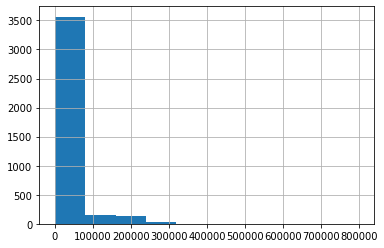

In [293]:
df_final['Salary_from'].hist()

In [294]:

df_final['Salary_to'] = df_final['Salary_to'].replace(r'\s+','',regex=True)
df_final['Salary_to'] = df_final['Salary_to'].replace({'4,500': '4.500' , '3,500': '3.500', '2,500': '2.500' 
                                                           ,'3,400': '3.400', '250,000': '250.000', '200,000': '200.000'
                                                           , '2,000': '2.000' , '2,5': '2.5','3,5': '3.5', '1,4': '1.4'
                                                            ,'3,000': '3.000','150,000': '150.000'
                                                            , '7,000': '7.000', '3,200': '3.200', "180\'000" : '180.000'
                                                            , '300,000' : '300.000' ,'400,000' : '400.000','5,500': '5.500' 
                                                       , '1,000': '1.000' ,'4,4': '4.4', '1,500': '1.500', '1,6': '1.6' })

df_final['Salary_to']=df_final['Salary_to'].astype(float)

In [295]:

df_final['Salary_to'] = df_final['Salary_to'].replace(r'\s+','',regex=True)
df_final['Salary_to'] = df_final['Salary_to'].replace({'4,500': '4.500' , '3,500': '3.500', '2,500': '2.500' 
                                                           ,'3,400': '3.400', '250,000': '250.000', '200,000': '200.000'
                                                           , '2,000': '2.000' , '2,5': '2.5','3,5': '3.5', '1,4': '1.4'
                                                            ,'3,000': '3.000','150,000': '150.000'
                                                            , '7,000': '7.000', '3,200': '3.200', "180\'000": '180.000' })



In [296]:
df_final['da'] = df_final['da'].astype(int)

In [297]:
df_final = df_final.drop(columns = [ 'text', 'blocks' ])

In [298]:
df_final = df_final.drop(columns = [ 'url' ])

In [299]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3887 entries, 276 to 4531
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   message_id          3887 non-null   int64         
 1   date                3887 non-null   datetime64[ns]
 2   title               3887 non-null   object        
 3   ds                  3887 non-null   int64         
 4   da                  3887 non-null   int64         
 5   de                  3887 non-null   int64         
 6   grade               3887 non-null   object        
 7   type_office         3887 non-null   object        
 8   city                3887 non-null   object        
 9   name_vacancy        3887 non-null   object        
 10  TensorFlow          3887 non-null   int64         
 11  PyTorch             3887 non-null   int64         
 12  Keras               3887 non-null   int64         
 13  Python              3887 non-null   int64     

In [300]:
#df_final = df.drop(columns  = ['chat_id', 'url', 'parsed_text', 'text_copy', 'clean_text', 'salary_from'])

In [301]:
df_final['da'].unique()

array([1, 0])

In [302]:
# df_final['year'] = pd.to_datetime(df_final['year'])
# df_final['month'] = pd.to_datetime(df_final['month'])
# df_final['day'] = pd.to_datetime(df_final['day'])
# df_final['time'] = df_final['month']
df_final['year'] = df_final['date'].dt.year
df_final['month'] = df_final['date'].dt.month
df_final['day'] = df_final['date'].dt.day

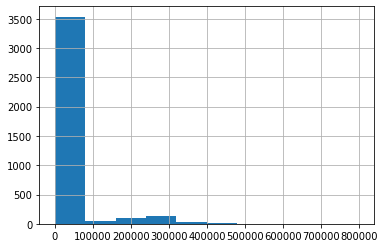

In [303]:
df_final['Salary_to'].hist()

In [304]:
df_final.pivot_table(
    index='month',
    values = ['Salary_to'],
    aggfunc = 'mean'
)

,Salary_to
month,
1,17396.929526
2,19715.975787
3,17430.779566
4,20064.375778
5,32395.283721
6,25450.183772
7,33002.755657
8,13115.489606
9,29693.177193


In [305]:
list_sal = df_final.query('cur== "Rub"').groupby('Salary_from')['message_id'].count()

In [306]:
list_sal.head(30)

Salary_from
0.00     2296
1.40        1
1.50        1
2.00        1
2.50        1
3.00        2
4.50        1
6.10        3
8.00        5
9.00       13
9.30        3
10.00      12
11.00       1
12.00       3
13.00       1
14.00       1
15.00       2
18.00       2
19.11       1
20.00       9
21.00      10
22.00       1
25.00       1
26.00       1
29.00       1
30.00      12
35.00       3
40.00       9
45.00       2
50.00       6
Name: message_id, dtype: int64

In [307]:
df_final.to_csv('df_final.csv')


In [308]:
from google.colab import files
files.download('df_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ссылки на Дашборды:

DA:  https://public.tableau.com/views/Masterskaya_parser_DA/_DA?:language=en-US&:display_count=n&:origin=viz_share_link


 DS: https://public.tableau.com/views/Masterskaya_parser_DS/_DS?:language=en-US&:display_count=n&:origin=viz_share_link


 
